# Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision.models import ResNet50_Weights, resnet50
from torchvision.transforms import v2

In [2]:
# set a seed for deterministic results
random_state = 42
torch.manual_seed(random_state)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Pre-Processing

## Load Dataset

In [4]:
# initial transforms
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ]
)

In [5]:
trainset = CIFAR10(root='./dataset', train=True , transform=transforms, download=True)
testset  = CIFAR10(root='./dataset', train=False, transform=transforms, download=True)

# log
print('trainset:')
print(f"    -> trainset.data.shape    : {trainset.data.shape}")
print(f"    -> trainset.data.dtype    : {trainset.data.dtype}")
print(f"    -> type(trainset.data)    : {type(trainset.data)}")
print(f"    -> type(trainset.targets) : {type(trainset.targets)}")
print('-' * 50)
print('testset:')
print(f"    -> testset.data.shape     : {testset.data.shape}")
print(f"    -> testset.data.dtype     : {testset.data.dtype}")
print(f"    -> type(testset.data)     : {type(testset.data)}")
print(f"    -> type(testset.targets)  : {type(testset.targets)}")
print('-' * 50)
print(f"classes : {trainset.classes}")
print(f"trainset distribution : {np.unique(trainset.targets, return_counts=True)[1]}")
print(f"testset  distribution : {np.unique(testset.targets, return_counts=True)[1]}")

Files already downloaded and verified
Files already downloaded and verified
trainset:
    -> trainset.data.shape    : (50000, 32, 32, 3)
    -> trainset.data.dtype    : uint8
    -> type(trainset.data)    : <class 'numpy.ndarray'>
    -> type(trainset.targets) : <class 'list'>
--------------------------------------------------
testset:
    -> testset.data.shape     : (10000, 32, 32, 3)
    -> testset.data.dtype     : uint8
    -> type(testset.data)     : <class 'numpy.ndarray'>
    -> type(testset.targets)  : <class 'list'>
--------------------------------------------------
classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
trainset distribution : [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
testset  distribution : [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


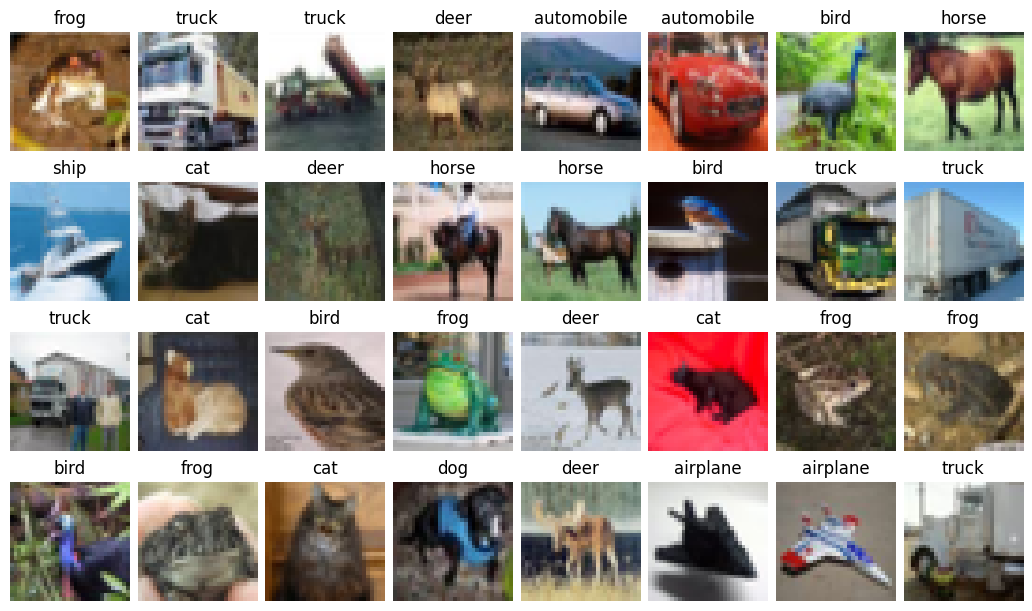

In [6]:
# plot
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(12, 6), layout='compressed')
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(trainset.data[i * 8 + j], cmap='gray')
        axs[i, j].set_title(trainset.classes[trainset.targets[i * 8 + j]])
        axs[i, j].axis('off')
plt.show()

## Normalization

In [7]:
data = next(iter(DataLoader(trainset, batch_size=len(trainset))))[0]

train_mean = data.mean(axis=(0, 2, 3))
train_std = data.std(axis=(0, 2, 3))

del data

# log
print(f"train mean per channel : {train_mean}")
print(f"train std  per channel : {train_std}")

train mean per channel : tensor([0.4914, 0.4822, 0.4465])
train std  per channel : tensor([0.2470, 0.2435, 0.2616])


In [8]:
transforms.transforms.append(v2.Normalize(mean=train_mean, std=train_std))

# log
print(f"trainset.transforms:\n{trainset.transforms}\n")
print(f"testset.transforms:\n{testset.transforms}")

trainset.transforms:
StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[tensor(0.4914), tensor(0.4822), tensor(0.4465)], std=[tensor(0.2470), tensor(0.2435), tensor(0.2616)], inplace=False)
           )

testset.transforms:
StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[tensor(0.4914), tensor(0.4822), tensor(0.4465)], std=[tensor(0.2470), tensor(0.2435), tensor(0.2616)], inplace=False)
           )


In [9]:
# log
print("before applying transform:")
print(f"    -> type(testset.data[0]) : {type(testset.data[0])}")
print(f"    -> testset.data[0].dtype : {testset.data[0].dtype}")
print(f"    -> testset.data[0].shape : {testset.data[0].shape}")
print('-' * 50)
print("after applying transform:")
print(f"    -> type(testset[0][0])   : {type(testset[0][0])}")
print(f"    -> testset[0][0].dtype   : {testset[0][0].dtype}")
print(f"    -> testset[0][0].shape   : {testset[0][0].shape}")

before applying transform:
    -> type(testset.data[0]) : <class 'numpy.ndarray'>
    -> testset.data[0].dtype : uint8
    -> testset.data[0].shape : (32, 32, 3)
--------------------------------------------------
after applying transform:
    -> type(testset[0][0])   : <class 'torchvision.tv_tensors._image.Image'>
    -> testset[0][0].dtype   : torch.float32
    -> testset[0][0].shape   : torch.Size([3, 32, 32])


## DataLoader

In [10]:
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True , num_workers=2)
testloader  = DataLoader(testset , batch_size=batch_size, shuffle=False, num_workers=2)

# Transfer Learning
   - resnet50 pretrained on IMAGENET1K_V1

In [11]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# log
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
summary(resnet, input_size=(1, *trainset[0][0].shape), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─ReLU: 1-3                              [1, 64, 16, 16]           --
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Sequential: 1-5                        [1, 256, 8, 8]            --
│    └─Bottleneck: 2-1                   [1, 256, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-6                    [1, 64, 8, 8]             --
│ 

## Extract a subset of Pretrained Model

In [13]:
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

# log
for name, param in feature_extractor.named_parameters():
    print(f"{name:<23} - requires_grad: {param.requires_grad}")

0.weight                - requires_grad: True
1.weight                - requires_grad: True
1.bias                  - requires_grad: True
4.0.conv1.weight        - requires_grad: True
4.0.bn1.weight          - requires_grad: True
4.0.bn1.bias            - requires_grad: True
4.0.conv2.weight        - requires_grad: True
4.0.bn2.weight          - requires_grad: True
4.0.bn2.bias            - requires_grad: True
4.0.conv3.weight        - requires_grad: True
4.0.bn3.weight          - requires_grad: True
4.0.bn3.bias            - requires_grad: True
4.0.downsample.0.weight - requires_grad: True
4.0.downsample.1.weight - requires_grad: True
4.0.downsample.1.bias   - requires_grad: True
4.1.conv1.weight        - requires_grad: True
4.1.bn1.weight          - requires_grad: True
4.1.bn1.bias            - requires_grad: True
4.1.conv2.weight        - requires_grad: True
4.1.bn2.weight          - requires_grad: True
4.1.bn2.bias            - requires_grad: True
4.1.conv3.weight        - requires

## Freeze all transferred layers

In [14]:
for name, param in resnet.named_parameters():
    param.requires_grad = False

# log
for name, param in resnet.named_parameters():
    print(f"{name:<28} - requires_grad : {param.requires_grad}")

conv1.weight                 - requires_grad : False
bn1.weight                   - requires_grad : False
bn1.bias                     - requires_grad : False
layer1.0.conv1.weight        - requires_grad : False
layer1.0.bn1.weight          - requires_grad : False
layer1.0.bn1.bias            - requires_grad : False
layer1.0.conv2.weight        - requires_grad : False
layer1.0.bn2.weight          - requires_grad : False
layer1.0.bn2.bias            - requires_grad : False
layer1.0.conv3.weight        - requires_grad : False
layer1.0.bn3.weight          - requires_grad : False
layer1.0.bn3.bias            - requires_grad : False
layer1.0.downsample.0.weight - requires_grad : False
layer1.0.downsample.1.weight - requires_grad : False
layer1.0.downsample.1.bias   - requires_grad : False
layer1.1.conv1.weight        - requires_grad : False
layer1.1.bn1.weight          - requires_grad : False
layer1.1.bn1.bias            - requires_grad : False
layer1.1.conv2.weight        - requires_grad :

## Transfer the model

In [15]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


model = MyModel()

# log
model.to(device)

MyModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [16]:
for name, param in model.named_parameters():
    print(f"{name:<41} - requires_grad : {param.requires_grad}")

feature_extractor.0.weight                - requires_grad : False
feature_extractor.1.weight                - requires_grad : False
feature_extractor.1.bias                  - requires_grad : False
feature_extractor.4.0.conv1.weight        - requires_grad : False
feature_extractor.4.0.bn1.weight          - requires_grad : False
feature_extractor.4.0.bn1.bias            - requires_grad : False
feature_extractor.4.0.conv2.weight        - requires_grad : False
feature_extractor.4.0.bn2.weight          - requires_grad : False
feature_extractor.4.0.bn2.bias            - requires_grad : False
feature_extractor.4.0.conv3.weight        - requires_grad : False
feature_extractor.4.0.bn3.weight          - requires_grad : False
feature_extractor.4.0.bn3.bias            - requires_grad : False
feature_extractor.4.0.downsample.0.weight - requires_grad : False
feature_extractor.4.0.downsample.1.weight - requires_grad : False
feature_extractor.4.0.downsample.1.bias   - requires_grad : False
feature_ex

In [17]:
summary(model, input_size=(1, *trainset[0][0].shape))

Layer (type:depth-idx)                        Output Shape              Param #
MyModel                                       [1, 10]                   --
├─Sequential: 1-1                             [1, 2048, 1, 1]           --
│    └─Conv2d: 2-1                            [1, 64, 16, 16]           (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 16, 16]           (128)
│    └─ReLU: 2-3                              [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                         [1, 64, 8, 8]             --
│    └─Sequential: 2-5                        [1, 256, 8, 8]            --
│    │    └─Bottleneck: 3-1                   [1, 256, 8, 8]            (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 8, 8]            (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 8, 8]            (70,400)
│    └─Sequential: 2-6                        [1, 512, 4, 4]            --
│    │    └─Bottleneck: 3-4                   [1, 512, 4, 4]         

# Set up remaining Hyper-Parameters

In [18]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=lr)
num_epochs = 3

# Train Loop

In [19]:
train_acc_per_epoch = []
train_loss_per_epoch = []
train_acc = Accuracy(task='multiclass', num_classes=len(testset.classes), top_k=1).to(device)

In [20]:
for epoch in range(num_epochs):

    model.train()
    train_loss = 0

    for x, y in trainloader:

        # send data to GPU
        x, y_true = x.to(device), y.to(device)

        # forward
        y_pred = model(x)
        loss = criterion(y_pred, y_true)

        # backward
        loss.backward()

        # update parameters
        optimizer.step()
        optimizer.zero_grad()

        # log loss & accuracy
        train_loss += loss.item() * len(x)
        train_acc.update(y_pred, y_true)

    train_loss_per_epoch.append(train_loss / len(trainset))
    train_acc_per_epoch.append(train_acc.compute().item())
    train_acc.reset()

    # log
    print(f"epoch {epoch:>2}  ->  train[loss: {train_loss_per_epoch[epoch]:.5f} - acc: {train_acc_per_epoch[epoch]:.2f}]")

epoch  0  ->  train[loss: 1.60624 - acc: 0.44]
epoch  1  ->  train[loss: 1.43747 - acc: 0.49]
epoch  2  ->  train[loss: 1.38375 - acc: 0.51]
